# Requirements

### Installs Required

In [1]:
# Install required packages
%pip install torch torchvision torchaudio numpy matplotlib pandas scikit-learn seaborn torchinfo pillow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Imports Required

In [1]:
# Import necessary libraries
import os
import re
import zipfile
import vcpi_util

import torch

import torch.utils
import torchvision
from torchvision.transforms import v2

from PIL import Image

import numpy as np
import time
import collections

### Zip File Extraction

In [ ]:
# Function to extract .ppm files from a zip archive
def extract_ppm_files(zipfile_path, extract_dir):
    # Create the extraction directory if it doesn't exist
    os.makedirs(extract_dir, exist_ok=True)

    # Open the zip file and extract .ppm files
    with zipfile.ZipFile(zipfile_path, "r") as zip_ref:
        ppm_files = [
            name for name in zip_ref.namelist() if name.lower().endswith(".ppm")
        ]
        for ppm_file in ppm_files:
            zip_ref.extract(ppm_file, path=extract_dir)

# Define paths for test and train zip files and extraction directories
test_zipfile_path = "test_images.zip"
train_zipfile_path = "train_images.zip"

test_extract_dir = "test_images"
train_extract_dir = "train_images"

# Extract .ppm files from the zip archives
extract_ppm_files(test_zipfile_path, test_extract_dir)
extract_ppm_files(train_zipfile_path, train_extract_dir)

### PPM to PNG converter

In [2]:
# Function to convert .ppm files to .png format
def convert_ppm_to_png(ppm_file):
    img = Image.open(ppm_file)
    png_file = os.path.splitext(ppm_file)[0] + ".png"
    img.save(png_file, "PNG")

# Function to convert .ppm files to .png and remove the original .ppm files
def convert_and_cleanup_folder(input_dir):
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(".ppm"):
                ppm_file = os.path.join(root, file)
                convert_ppm_to_png(ppm_file)
                os.remove(ppm_file)
            elif file.lower().endswith(".png"):
                os.path.join(root, file)

# Define directories for test and train images
test_dir = "test_images"
train_dir = "train_images/GTSRB/Final_Training/Images"

# Convert .ppm files to .png and clean up the folders
convert_and_cleanup_folder(test_dir)
convert_and_cleanup_folder(train_dir)

### Universal Variables

In [3]:
# Define constants for batch size, image size, and number of epochs
BATCH_SIZE = 32
IMAGE_SIZE = 32
EPOCHS = 20

### Device Designation

In [4]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Set device to GPU
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


# Functions/Classes for the Model Creation, Training and Evaluation

In [5]:
# Define the model architecture
class Model(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Define layers
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2)

        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bn3 = torch.nn.BatchNorm2d(48)
        self.relu3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bn4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()

        self.maxpool2 = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(1200, num_classes)

    def forward(self, x):
        # Forward pass through layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)

        return x


# Training function
def train(
    model,
    train_loader,
    val_loader,
    epochs,
    loss_fn,
    optimizer,
    scheduler,
    early_stopper,
    save_prefix="model",
):

    # Initialize history for storing metrics
    history = {}
    history["accuracy"] = []
    history["val_acc"] = []
    history["val_loss"] = []
    history["loss"] = []
    best_val_loss = np.inf

    for epoch in range(epochs):
        # Set model to train mode
        model.train()
        start_time = time.time()
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader, 0):

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            loss = loss_fn(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

            # Evaluate model on validation set
        model.eval()
        with torch.no_grad():
            v_correct = 0
            val_loss = 0.0
            for i, t in val_loader:
                i = i.to(device)
                t = t.to(device)
                o = model(i)
                _, p = torch.max(o, 1)

                val_loss += loss_fn(o, t)

                v_correct += (p == t).sum()

        # Adjust learning rate based on validation loss
        old_lr = optimizer.param_groups[0]["lr"]
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]["lr"]

        if old_lr != new_lr:
            print("==> Learning rate updated: ", old_lr, " -> ", new_lr)

        # Calculate metrics
        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / len(train_loader.dataset)
        v_accuracy = 100 * v_correct / len(val_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        stop_time = time.time()
        print(
            f"Epoch: {epoch:03d}; Loss: {epoch_loss:0.6f}; Accuracy: {accuracy:0.4f}; Val Loss: {val_loss:0.6f}; Val Acc: {v_accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}"
        )

        # Save metrics to history
        history["accuracy"].append(accuracy.cpu().numpy())
        history["val_acc"].append(v_accuracy.cpu().numpy())
        history["val_loss"].append(val_loss.cpu().detach().numpy())
        history["loss"].append(epoch_loss.cpu().detach().numpy())

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Save model checkpoint
            torch.save(
                {
                    "epoch": epoch,
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "scheduler": scheduler.state_dict(),
                },
                f"{save_prefix}_{epoch}.pt",
            )
        # Check for early stopping
        if early_stopper(val_loss):
            print("Early stopping!")
            break

    print("Finished Training")

    return history


# Evaluation function
def evaluate(model, data_loader):

    model.eval()

    correct = 0

    for i, (images, targets) in enumerate(data_loader):

        outputs = model(images.to(device))

        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()


# Early stopping class
class Early_Stopping:

    def __init__(self, patience=3, min_delta=0.00001):

        self.patience = patience
        self.min_delta = min_delta

        self.min_delta
        self.min_val_loss = float("inf")

    def __call__(self, val_loss):

        # improvement
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0

        # no improvement
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True

        return False


# Custom dataset class to handle subset of ImageFolder
class SubsetImageFolder(torch.utils.data.Dataset):
    def __init__(self, subset):
        self.subset = subset
        self.dataset = subset.dataset
        self.indices = subset.indices
        self.transform = self.dataset.transform
        self.target_transform = self.dataset.target_transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

# Base Model

In [6]:
# Define image transformations
image_reshape = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

### Test Dataset

In [7]:
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=image_reshape)
test_iterator = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

### First Dataset

In [8]:
# Load datasets and create data loaders
train_dataset = torchvision.datasets.ImageFolder(
    root=train_dir, transform=image_reshape
)

total_length = len(train_dataset)
train_length = int(0.8 * total_length)
validation_length = total_length - train_length

partial_train_dataset, validation_dataset = torch.utils.data.random_split(
    train_dataset, [train_length, validation_length]
)

partial_train_dataset = SubsetImageFolder(partial_train_dataset)
validation_dataset = SubsetImageFolder(validation_dataset)

partial_train_iterator = torch.utils.data.DataLoader(
    partial_train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
validation_iterator = torch.utils.data.DataLoader(
    validation_dataset, batch_size=BATCH_SIZE
)

In [9]:
images, labels = next(iter(partial_train_iterator))
print("Batch shape: ", images.shape)

print(labels)

Batch shape:  torch.Size([32, 3, 32, 32])
tensor([12, 22,  1,  5, 40, 18,  9,  4, 29, 15,  2,  2, 11,  5, 16, 26, 41, 13,
         1,  3,  1, 11, 13, 17, 35, 35, 25, 35, 10,  4, 38, 21])


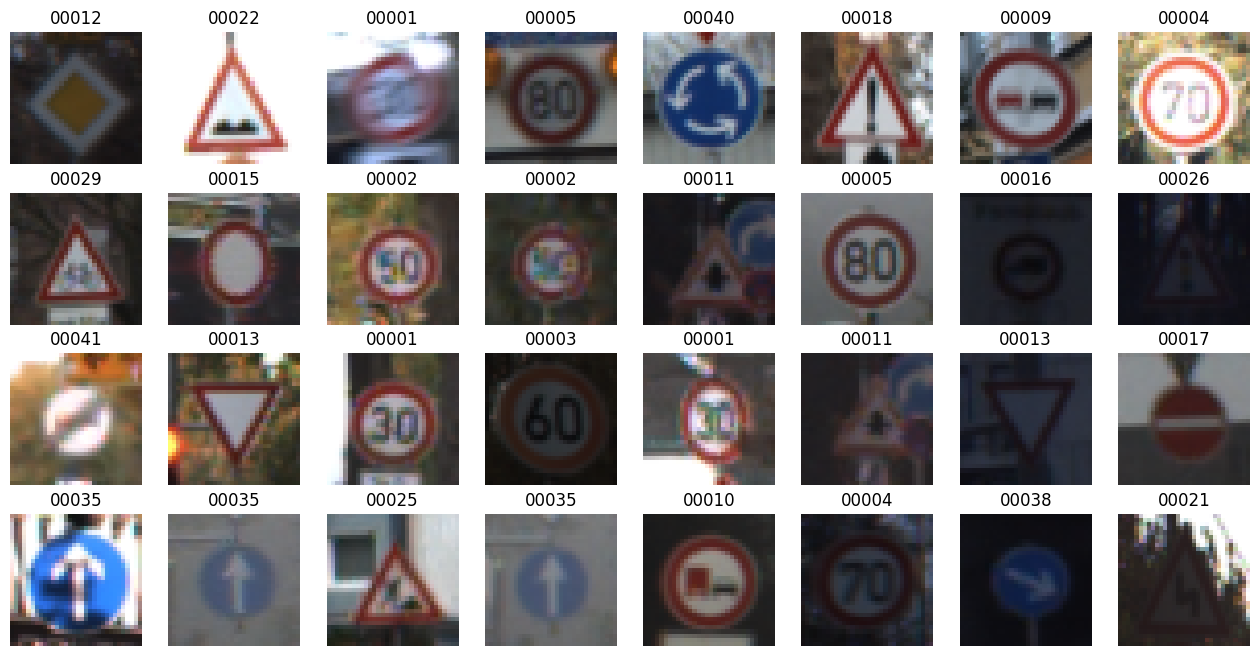

<Figure size 640x480 with 0 Axes>

In [10]:
vcpi_util.show_images(4, 8, images, labels, train_dataset.classes)

### Model

In [11]:
train_model = Model(len(train_dataset.classes))
train_model.to(device)

optimizer = torch.optim.Adam(train_model.parameters())
optimizer_aux = torch.optim.Adam(train_model.parameters(), lr=0.001)

loss_fn = torch.nn.CrossEntropyLoss()
early_stop = Early_Stopping(9)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_aux, 10, 0.001)

for epoch in range(50):
    optimizer_aux.step()
    scheduler.step()

history = train(
    train_model,
    partial_train_iterator,
    validation_iterator,
    EPOCHS,
    loss_fn,
    optimizer,
    scheduler,
    early_stop,
    "base_model",
)   

evaluate(train_model, test_iterator)

/home/tomas/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 000; Loss: 0.009644; Accuracy: 92.2785; Val Loss: 0.001445; Val Acc: 98.9033; Elapsed time: 337.8220
Epoch: 001; Loss: 0.000937; Accuracy: 99.2444; Val Loss: 0.001379; Val Acc: 98.7758; Elapsed time: 23.8758
Epoch: 002; Loss: 0.000544; Accuracy: 99.5027; Val Loss: 0.001073; Val Acc: 98.9799; Elapsed time: 26.2681
Epoch: 003; Loss: 0.000589; Accuracy: 99.4421; Val Loss: 0.000904; Val Acc: 99.3752; Elapsed time: 26.9760
Finished Training


0.9643705487251282

# Data Augmentation

### Augmentation Compositations (grouped by levels)

In [12]:
# Define data augmentation transformations

basic_augmentation = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        v2.GaussianBlur(kernel_size=3, sigma=1.0),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

moderate_augmentation = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomRotation(degrees=10),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

advanced_augmentation = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomRotation(degrees=15),
        v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
        v2.GaussianBlur(kernel_size=3, sigma=(0.5, 1.5)),
        v2.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
        v2.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

### Level 1 - Basic Augmentation

In [13]:
# Load augmented datasets for training
train_dataset = torchvision.datasets.ImageFolder(
    root=train_dir, transform=basic_augmentation
)

total_length = len(train_dataset)
train_length = int(0.8 * total_length)
validation_length = total_length - train_length

partial_train_dataset, validation_dataset = torch.utils.data.random_split(
    train_dataset, [train_length, validation_length]
)

partial_train_dataset = SubsetImageFolder(partial_train_dataset)
validation_dataset = SubsetImageFolder(validation_dataset)

print(partial_train_dataset)
print(validation_dataset)

partial_train_iterator = torch.utils.data.DataLoader(
    partial_train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
validation_iterator = torch.utils.data.DataLoader(
    validation_dataset, batch_size=BATCH_SIZE
)

In [14]:
images, labels = next(iter(partial_train_iterator))
print("Batch shape: ", images.shape)

print(labels)

Batch shape:  torch.Size([32, 3, 32, 32])
tensor([37,  8, 25,  7, 35,  1,  5, 18, 34, 25, 38,  4, 33,  2, 35, 22, 10, 18,
        17, 15,  1, 31, 12, 13,  4, 15, 14,  2, 34, 20, 36, 42])


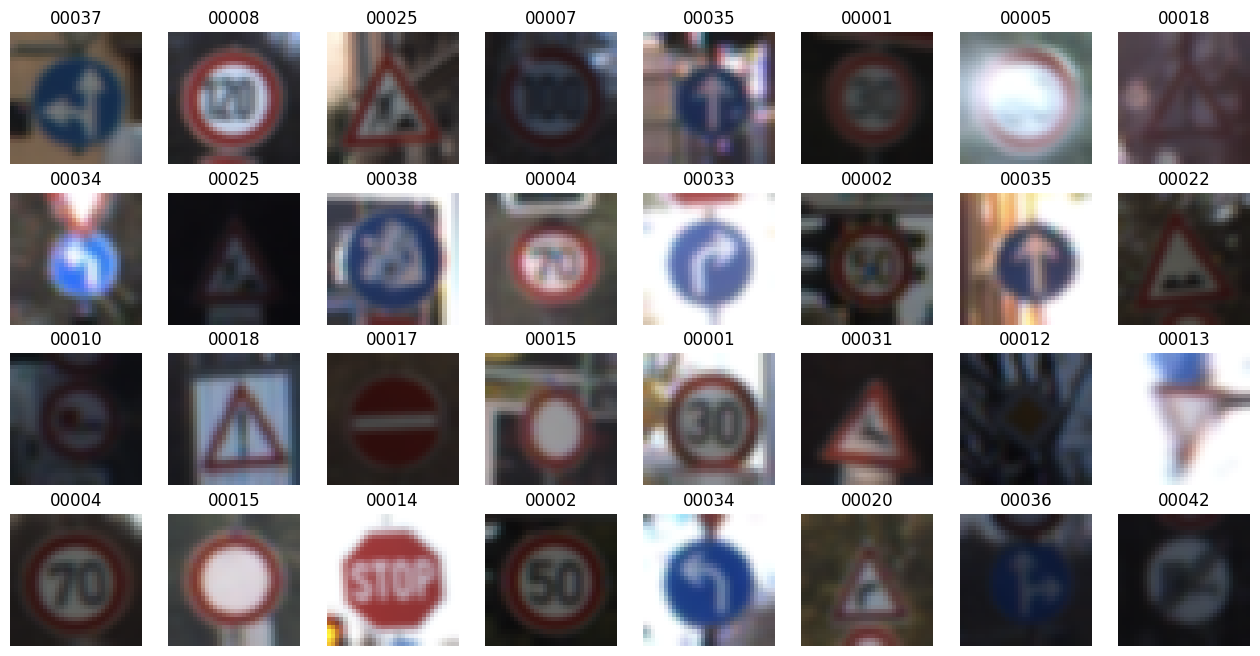

<Figure size 640x480 with 0 Axes>

In [15]:
vcpi_util.show_images(4, 8, images, labels, train_dataset.classes)

In [16]:
# Train the model with different data augmentation settings
train_model = Model(len(train_dataset.classes))
train_model.to(device)

optimizer = torch.optim.Adam(train_model.parameters())
optimizer_aux = torch.optim.Adam(train_model.parameters(), lr=0.001)

loss_fn = torch.nn.CrossEntropyLoss()
early_stop = Early_Stopping(9)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_aux, 10, 0.001)

for epoch in range(50):
    optimizer_aux.step()
    scheduler.step()

history = train(
    train_model,
    partial_train_iterator,
    validation_iterator,
    EPOCHS,
    loss_fn,
    optimizer,
    scheduler,
    early_stop,
    "basic_data_augmentation_model",
)

evaluate(train_model, test_iterator)

Epoch: 000; Loss: 0.011275; Accuracy: 90.8821; Val Loss: 0.002248; Val Acc: 98.2530; Elapsed time: 41.6265
Epoch: 001; Loss: 0.001196; Accuracy: 99.0372; Val Loss: 0.001319; Val Acc: 98.8651; Elapsed time: 42.2810
Epoch: 002; Loss: 0.000684; Accuracy: 99.4548; Val Loss: 0.001512; Val Acc: 98.6611; Elapsed time: 40.6393
Epoch: 003; Loss: 0.000602; Accuracy: 99.4006; Val Loss: 0.001358; Val Acc: 98.7503; Elapsed time: 43.0751
Finished Training


0.9477434754371643

### Level 2 - Moderate Augmentation

In [17]:
# Load augmented datasets for training
train_dataset = torchvision.datasets.ImageFolder(
    root=train_dir, transform=moderate_augmentation
)

total_length = len(train_dataset)
train_length = int(0.8 * total_length)
validation_length = total_length - train_length

partial_train_dataset, validation_dataset = torch.utils.data.random_split(
    train_dataset, [train_length, validation_length]
)

partial_train_dataset = SubsetImageFolder(partial_train_dataset)
validation_dataset = SubsetImageFolder(validation_dataset)

print(partial_train_dataset)
print(validation_dataset)

partial_train_iterator = torch.utils.data.DataLoader(
    partial_train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
validation_iterator = torch.utils.data.DataLoader(
    validation_dataset, batch_size=BATCH_SIZE
)

In [18]:
images, labels = next(iter(partial_train_iterator))
print("Batch shape: ", images.shape)

print(labels)

Batch shape:  torch.Size([32, 3, 32, 32])
tensor([38, 16,  6, 28, 36, 18, 40, 10,  1, 10, 25, 10, 10,  9,  1, 11, 38, 13,
        22, 14,  2, 23, 13,  1, 15,  5, 19, 34,  4, 38, 28,  4])


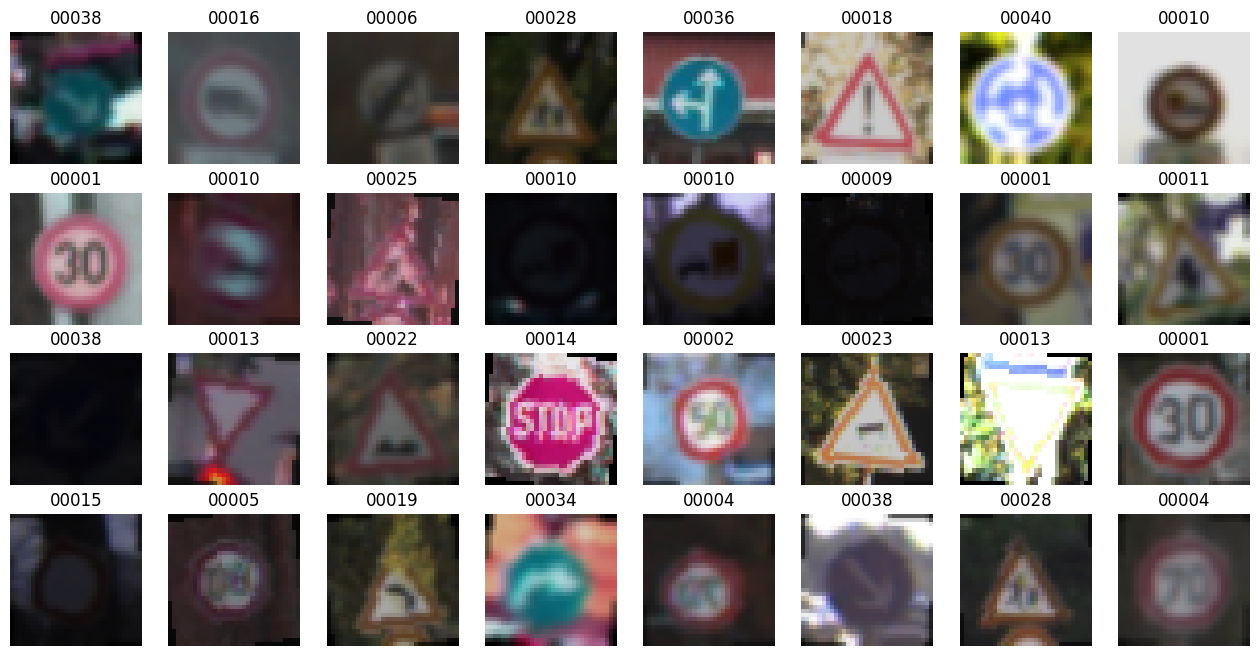

<Figure size 640x480 with 0 Axes>

In [19]:
vcpi_util.show_images(4, 8, images, labels, train_dataset.classes)

In [20]:
# Train the model with different data augmentation settings
train_model = Model(len(train_dataset.classes))
train_model.to(device)

optimizer = torch.optim.Adam(train_model.parameters())
optimizer_aux = torch.optim.Adam(train_model.parameters(), lr=0.001)

loss_fn = torch.nn.CrossEntropyLoss()
early_stop = Early_Stopping(9)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_aux, 10, 0.001)

for epoch in range(50):
    optimizer_aux.step()
    scheduler.step()

history = train(
    train_model,
    partial_train_iterator,
    validation_iterator,
    EPOCHS,
    loss_fn,
    optimizer,
    scheduler,
    early_stop,
    "moderate_data_augmentation_model",
)

evaluate(train_model, test_iterator)

Epoch: 000; Loss: 0.020147; Accuracy: 81.3849; Val Loss: 0.006636; Val Acc: 93.4838; Elapsed time: 103.8627
Epoch: 001; Loss: 0.004937; Accuracy: 95.2338; Val Loss: 0.004971; Val Acc: 95.3966; Elapsed time: 108.9717
Epoch: 002; Loss: 0.003476; Accuracy: 96.6685; Val Loss: 0.003771; Val Acc: 96.4805; Elapsed time: 95.4305
Epoch: 003; Loss: 0.002784; Accuracy: 97.2870; Val Loss: 0.002954; Val Acc: 97.2328; Elapsed time: 96.7655
Finished Training


0.9482976794242859

### Level 3 - Advanced Augmentation

In [21]:
# Load augmented datasets for training
train_dataset = torchvision.datasets.ImageFolder(
    root=train_dir, transform=advanced_augmentation
)

total_length = len(train_dataset)
train_length = int(0.8 * total_length)
validation_length = total_length - train_length

partial_train_dataset, validation_dataset = torch.utils.data.random_split(
    train_dataset, [train_length, validation_length]
)

partial_train_dataset = SubsetImageFolder(partial_train_dataset)
validation_dataset = SubsetImageFolder(validation_dataset)

print(partial_train_dataset)
print(validation_dataset)

partial_train_iterator = torch.utils.data.DataLoader(
    partial_train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
validation_iterator = torch.utils.data.DataLoader(
    validation_dataset, batch_size=BATCH_SIZE
)

In [22]:
images, labels = next(iter(partial_train_iterator))
print("Batch shape: ", images.shape)

print(labels)

Batch shape:  torch.Size([32, 3, 32, 32])
tensor([ 8,  9, 12,  7,  9, 38, 11,  4,  3, 30, 20,  9, 16,  2, 14,  2, 11,  1,
         4, 35, 11, 13, 20, 12, 14, 12, 20, 24, 12, 31, 38, 10])


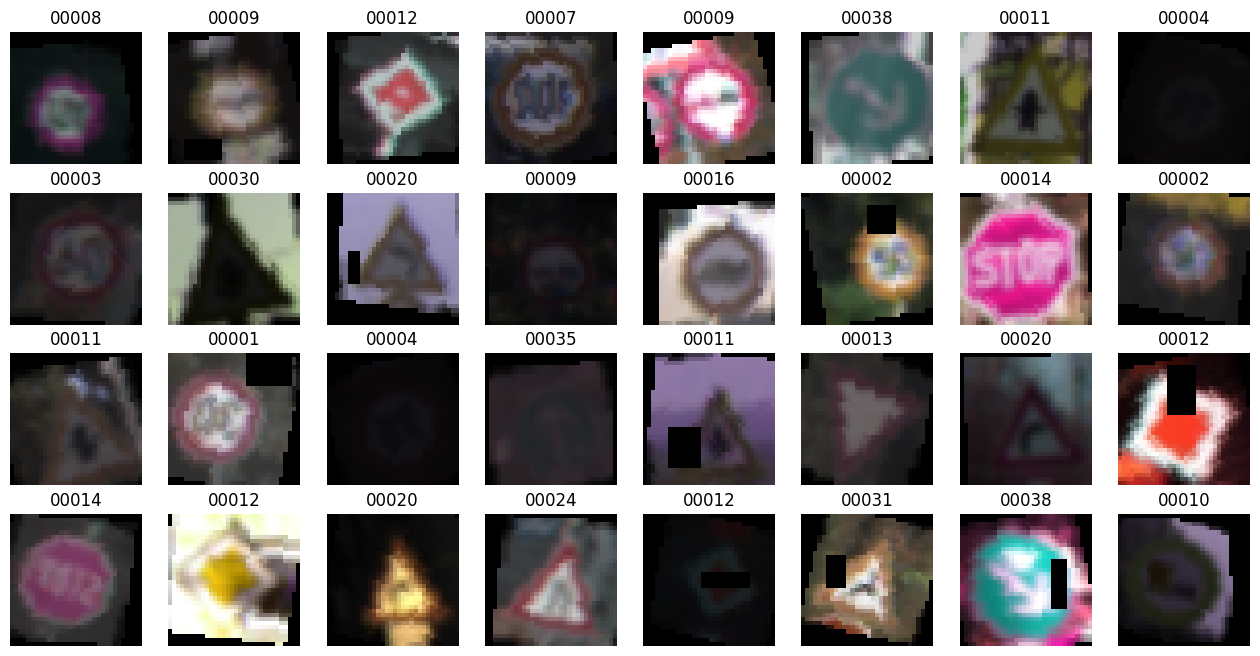

<Figure size 640x480 with 0 Axes>

In [23]:
vcpi_util.show_images(4, 8, images, labels, train_dataset.classes)

In [24]:
# Train the model with different data augmentation settings
train_model = Model(len(train_dataset.classes))
train_model.to(device)

optimizer = torch.optim.Adam(train_model.parameters())
optimizer_aux = torch.optim.Adam(train_model.parameters(), lr=0.001)

loss_fn = torch.nn.CrossEntropyLoss()
early_stop = Early_Stopping(9)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_aux, 10, 0.001)

for epoch in range(50):
    optimizer_aux.step()
    scheduler.step()

history = train(
    train_model,
    partial_train_iterator,
    validation_iterator,
    EPOCHS,
    loss_fn,
    optimizer,
    scheduler,
    early_stop,
    "advanced_data_augmentation_model",
)

evaluate(train_model, test_iterator)

/home/tomas/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 000; Loss: 0.051260; Accuracy: 50.8082; Val Loss: 0.029347; Val Acc: 70.7473; Elapsed time: 125.5015
Epoch: 001; Loss: 0.024221; Accuracy: 75.3690; Val Loss: 0.023108; Val Acc: 76.3071; Elapsed time: 122.5445
Epoch: 002; Loss: 0.017796; Accuracy: 81.6623; Val Loss: 0.015294; Val Acc: 84.0602; Elapsed time: 125.6672
Epoch: 003; Loss: 0.015028; Accuracy: 84.5698; Val Loss: 0.015847; Val Acc: 83.3971; Elapsed time: 352.9360
Finished Training


0.8992874026298523

# Ensemble

### Gather Models

In [25]:
def find_files_matching_regex(directory, pattern):
    matching_files = []
    regex = re.compile(pattern)

    for root, _, files in os.walk(directory):
        for file in files:
            if regex.match(file):
                matching_files.append(os.path.join(root, file))

    return matching_files

In [26]:
models = []
acc = []

directory = "."
pattern = r"(((aug_data_model)|(base_model)|(minimal_data_augmentation_model)|(basic_data_augmentation_model)|(moderate_data_augmentation_model)|(advanced_data_augmentation_model)|(intensive_data_augmentation_model))_\d+\.pt)"
model_files = find_files_matching_regex(directory, pattern)

index = 0
for file in model_files:
    reload = torch.load(f"{file}")
    model = Model(43)
    model.load_state_dict(reload["model"])
    model.to(device)
    models.append(model)
    acc.append(evaluate(models[index], test_iterator))
    index += 1

print(models)
print(acc)

[Model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1200, out_features=43, bias=True)
), Model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): Ba

### Ensemble Evaluation

In [27]:
# Define functions to get labels, logits, and predictions


def get_labels_logits_and_preds(models):

    with torch.no_grad():
        logits = [[] for _ in range(10)]
        labels = []

        for images, labs in test_iterator:

            images = images.to(device)
            labels.extend(labs)

            for i in range(10):
                logits[i].extend(models[i](images).cpu())

    return labels, logits


labels, logits = get_labels_logits_and_preds(models)

preds = [[] for _ in range(len(labels))]

for index in range(len(labels)):
    preds[index] = [np.argmax(logits[m][index].cpu().numpy()) for m in range(10)]


def get_class_from_sum_of_logits(logits):

    sum_logits = []

    for i in range(len(logits[0])):

        log = logits[0][i]
        for m in range(1, 10):
            log = np.add(log, logits[m][i])
        sum_logits.append(np.argmax(log))
    return sum_logits


class_logits = get_class_from_sum_of_logits(logits)


# Evaluate the ensemble of models on the test data
def get_stats(labels, class_preds, class_logits):

    all_correct = 0
    all_incorrect = 0
    maj_vote = 0
    maj_wrong = 0
    tie = 0
    count = 0

    for k in range(len(labels)):

        counter = collections.Counter(class_preds[k])
        if len(counter) == 1:
            if counter.most_common(1)[0][0] == labels[k]:
                all_correct += 1
            else:
                all_incorrect += 1
        else:
            aux = counter.most_common(2)
            if aux[0][1] > aux[1][1] and aux[0][0] == labels[k]:
                maj_vote += 1
            if aux[0][1] > aux[1][1] and aux[0][0] != labels[k]:
                maj_wrong += 1
            elif aux[0][1] == aux[1][1]:
                tie += 1

        count += 1

    return [count, all_correct, all_incorrect, maj_vote, tie, maj_wrong]


# Calculate statistics and performance metrics

res = get_stats(labels, preds, class_logits)
print("total: ", res[0])
print("All correct: ", res[1])
print("All incorrect: ", res[2])
print("Majority correct: ", res[3])
print("Tie Vote: ", res[4])
print("Majority Wrong: ", res[5])
print("Percentage right: ", (res[1] + res[3]) / res[0])

total:  12630
All correct:  10153
All incorrect:  3
Majority correct:  2193
Tie Vote:  79
Majority Wrong:  202
Percentage right:  0.977513855898654


### Model Cleanup

In [28]:
# Delete saved model files

directory = "."
pattern = r"(((aug_data_model)|(base_model)|(minimal_data_augmentation_model)|(basic_data_augmentation_model)|(moderate_data_augmentation_model)|(advanced_data_augmentation_model)|(intensive_data_augmentation_model))_\d+\.pt)"
model_files = find_files_matching_regex(directory, pattern)

for model in model_files:
    file_path = os.path.join(os.getcwd(), f"{model}")
    if os.path.isfile(file_path):
        os.remove(file_path)
        print(f"Deleted file: {file_path}")
    else:
        print(f"File not found: {file_path}")

Deleted file: /media/tomas/WORK_FOLDER/PERFIL_CG/VCPI/VC/Projetos/Grupo/./base_model_0.pt
Deleted file: /media/tomas/WORK_FOLDER/PERFIL_CG/VCPI/VC/Projetos/Grupo/./base_model_1.pt
Deleted file: /media/tomas/WORK_FOLDER/PERFIL_CG/VCPI/VC/Projetos/Grupo/./base_model_2.pt
Deleted file: /media/tomas/WORK_FOLDER/PERFIL_CG/VCPI/VC/Projetos/Grupo/./basic_data_augmentation_model_0.pt
Deleted file: /media/tomas/WORK_FOLDER/PERFIL_CG/VCPI/VC/Projetos/Grupo/./basic_data_augmentation_model_1.pt
Deleted file: /media/tomas/WORK_FOLDER/PERFIL_CG/VCPI/VC/Projetos/Grupo/./base_model_3.pt
Deleted file: /media/tomas/WORK_FOLDER/PERFIL_CG/VCPI/VC/Projetos/Grupo/./moderate_data_augmentation_model_0.pt
Deleted file: /media/tomas/WORK_FOLDER/PERFIL_CG/VCPI/VC/Projetos/Grupo/./moderate_data_augmentation_model_1.pt
Deleted file: /media/tomas/WORK_FOLDER/PERFIL_CG/VCPI/VC/Projetos/Grupo/./moderate_data_augmentation_model_2.pt
Deleted file: /media/tomas/WORK_FOLDER/PERFIL_CG/VCPI/VC/Projetos/Grupo/./moderate_dat